## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

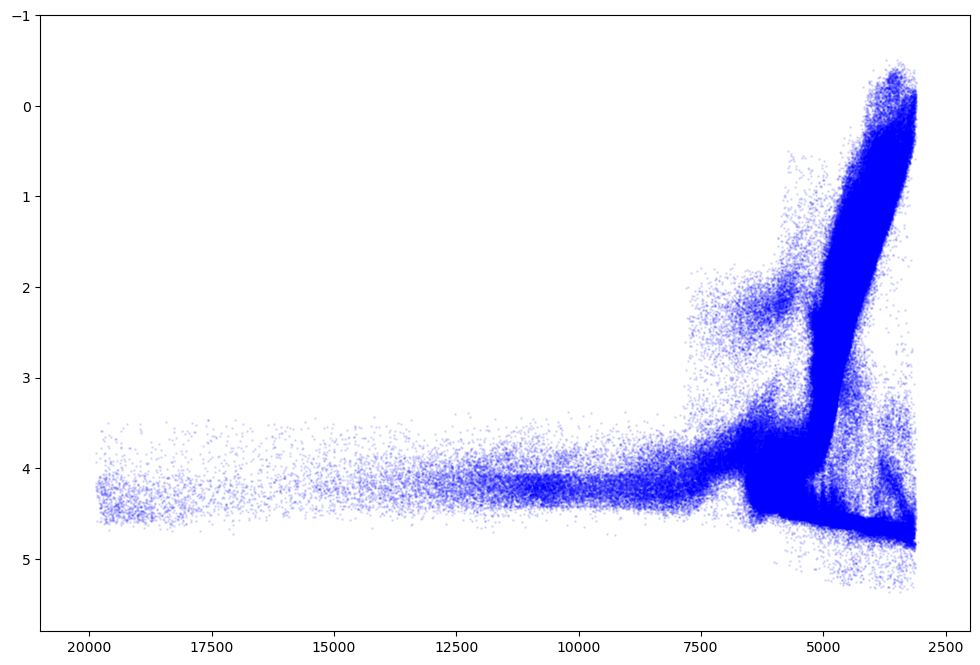

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.232, 0.054
POLY2: -0.073, -0.317, 0.048
POLY3: 0.075, 0.092, -0.262, 0.045


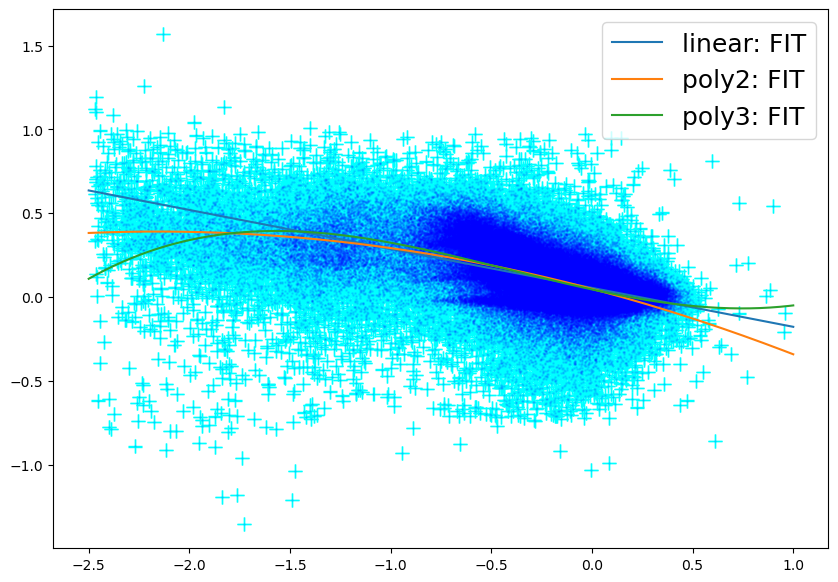

In [4]:
badbits = 2**23
suspectbits = 2**16

star = star[~np.isnan(star['FE_H'])]
star = star[~np.isnan(star['O_FE'])]
star = star[~np.isnan(star['FE_H_ERR'])]
star = star[~np.isnan(star['O_FE_ERR'])]
#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] > 20) 

cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1], p0=[0,0])

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1],star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0,0])

print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
polyA1, polyB1, polyC1, polyD1,  = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1],star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0,0,0])

print(f'POLY3: {polyA1:.3f}, {polyB1:.3f}, {polyC1:.3f}, {polyD1:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='cyan',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='poly2: FIT')

#poly3fit
ax1.plot(x_plot,poly3(x_plot, polyA1, polyB1, polyC1, polyD1, ), label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.137, 0.040
POLY2: -0.020, -0.146, 0.041
POLY3: 0.089, 0.129, -0.131, 0.033


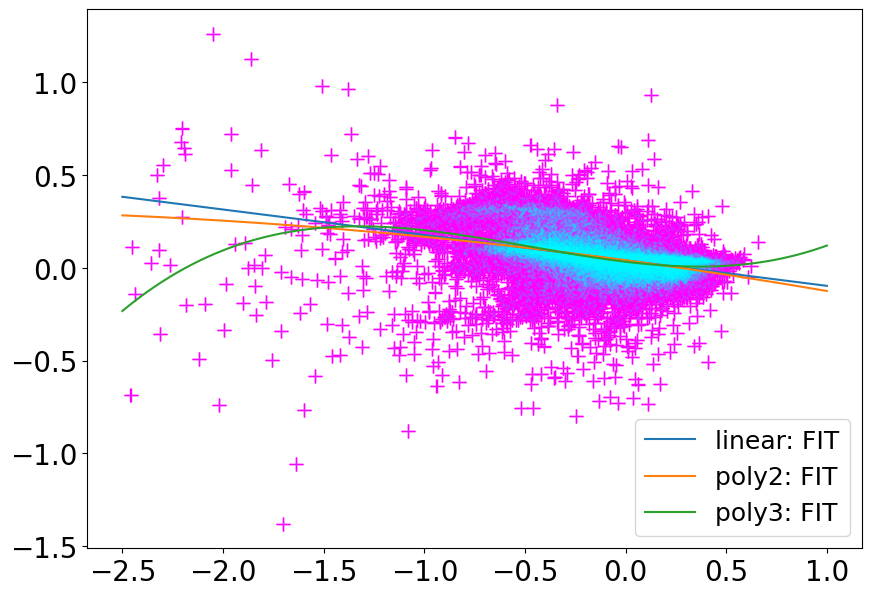

In [5]:
# write your fitting code, from part 1, and plot the results here
#Section 2 code

badbits = 2**23
suspectbits = 2**16

star = star[~np.isnan(star['FE_H'])]
star = star[~np.isnan(star['O_FE'])]
star = star[~np.isnan(star['FE_H_ERR'])]
star = star[~np.isnan(star['O_FE_ERR'])]
#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] < 1) & (star['GLAT'] > -1) 

cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0])

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0,0])

print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

## POLY3 FIT (4 parameter)
polyA1, polyB1, polyC1, polyD1,  = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1],star['Fe_H_ERR'][cut1], star['O_FE_ERR'][cut1],p0=[0,0,0,0])

print(f'POLY3: {polyA1:.3f}, {polyB1:.3f}, {polyC1:.3f}, {polyD1:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['Fe_H'][cut1],star['O_FE'][cut1],s=1,c='cyan',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1]),star['O_FE'][cut1], xerr=(star['FE_H_ERR'][cut1]/1000),
             yerr=(star['O_FE_ERR'][cut1]/1000), ecolor='fuchsia',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(-2.5,1,1000) # X-PLOTING FOR FITS

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC, ), label='poly2: FIT')

#poly3fit
ax1.plot(x_plot,poly3(x_plot, polyA1, polyB1, polyC1, polyD1, ), label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<b
                                                      r>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [6]:
# write your fitting code and plot the results here

badbits = 2**23
suspectbits = 2**16

star = star[~np.isnan(star['TEFF'])]
star = star[~np.isnan(star['LOGG'])]
star = star[~np.isnan(star['TEFF_ERR'])]
star = star[~np.isnan(star['LOGG_ERR'])]
#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLON'] < 360) & (star['GLON'] > 340) 

cut1 = np.where(ct1)[0]


## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1], p0=[0,0])

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

## EXPONENTIAL FIT (3 parameter)
expA, expB, expC, expD  = mcFit4(exponential, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], \
                         star['LOGG_ERR'][cut1],p0=[-73,-0.00035,-1.9,4.4]) 

print(f'EXPONENTIAL: {expA:.3f}, {expB:.3f}, {expC:.3f}, {expD:.3f}')

## POLY3 FIT (4 parameter)
polyA1, polyB1, polyC1, polyD1,  = mcFit4(poly3, star['TEFF'][cut1], star['LOGG'][cut1], star['TEFF_ERR'][cut1], star['LOGG_ERR'][cut1], p0=[1,1,1,1])

print(f'POLY3: {polyA1:.3f}, {polyB1:.3f}, {polyC1:.3f}, {polyD1:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1],star['LOGG'][cut1],s=1,c='cyan',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1]),star['LOGG'][cut1], xerr=(star['TEFF_ERR'][cut1]/1000),
             yerr=(star['LOGG_ERR'][cut1]), ecolor='b',fmt='none', capsize=5, zorder=0)


# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(21000,2000) # X-PLOTING FOR FITS

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')

#EXPONENTIAL fit
ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), label='exponential: FIT')

#poly3fit
ax1.plot(x_plot,poly3(x_plot, polyA1, polyB1, polyC1, polyD1 ), label='poly3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()

LINEAR: 0.001, -1.776


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.000, 2.333
POLY2: 0.000, -0.001, 3.894
POLY3: 0.000, -0.000, 0.001, 1.176


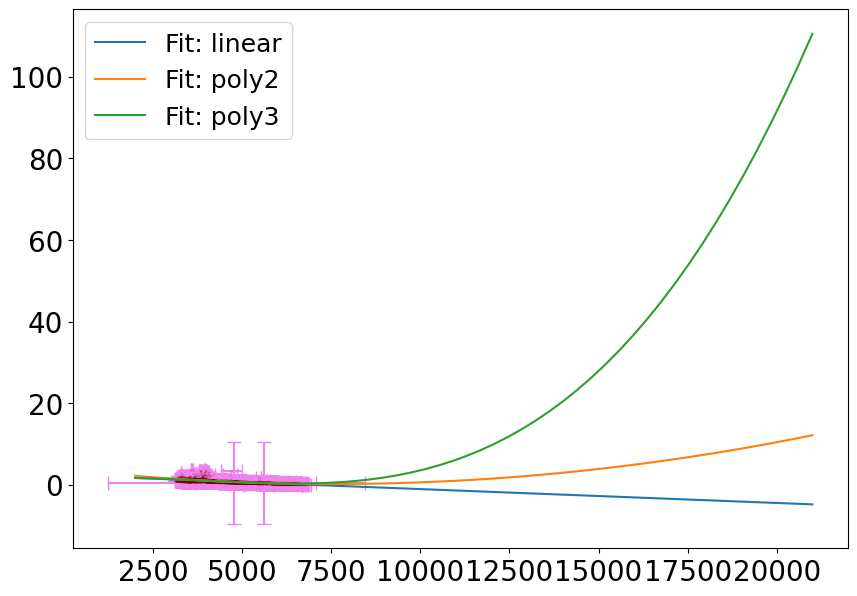

In [7]:
badbits = 2**23
suspectbits = 2**16

star = star[~np.isnan(star['TEFF'])]
star = star[~np.isnan(star['J_ERR'])]
star = star[~np.isnan(star['TEFF_ERR'])]
star = star[~np.isnan(star['K_ERR'])]
star = star[~np.isnan(star['K'])]
star = star[~np.isnan(star['J'])]
#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['DEC'] < -50) & (star['RA'] < 120) & (star['RA'] > 50) 

cut1 = np.where(ct1)[0]


J_K_ERR = np.sqrt((star['J_ERR'][cut1])**2 + (star['K_ERR'][cut1])**2)
J_K = star['J'][cut1] - star['K'][cut1]


slope, intercept = mcFit2(linear, star['TEFF'][cut1], J_K, star['TEFF_ERR'][cut1], \
                         J_K_ERR, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1], J_K, star['TEFF_ERR'][cut1], \
                         J_K_ERR,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['TEFF'][cut1], J_K, star['TEFF_ERR'][cut1], \
                         J_K_ERR,p0=[-1,0.5,1,10])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


# PLOT DATA AND ERROR BARS
ax1.errorbar((star['TEFF'][cut1]),J_K, xerr=(star['TEFF_ERR'][cut1]),
             yerr=(np.abs(J_K_ERR)), ecolor='violet',fmt='none', capsize=5, zorder=0)
ax1.scatter(star['TEFF'][cut1],J_K,s=1,c='maroon',alpha=0.1)


x_plot = np.linspace(21000,2000)


#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')

#log fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.006, -5.026
COSINE: 55.928, 0.023, 0.825, 0.880
POLY3: -0.000, 0.016, -2.093, 35.889


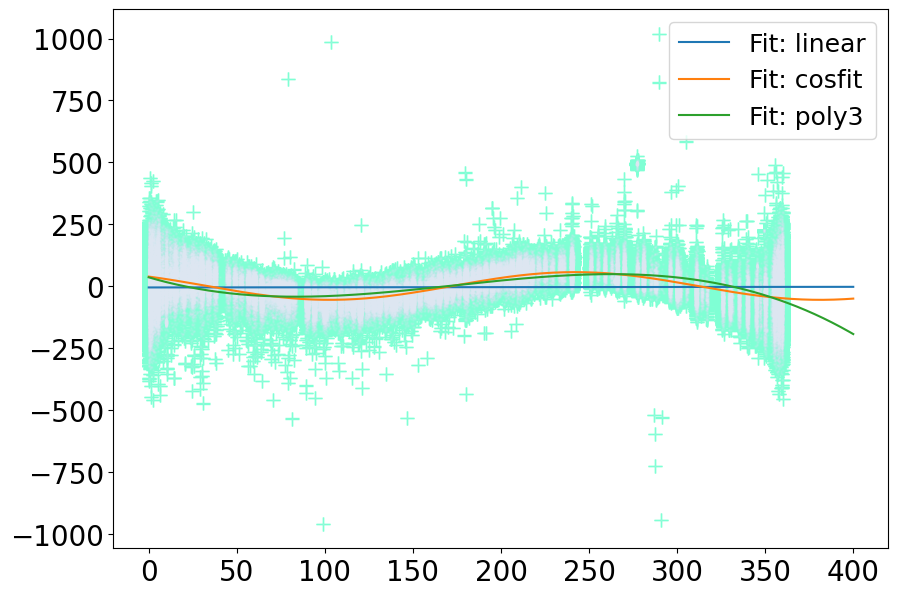

In [8]:
badbits = 2**23
suspectbits = 2**16

star = star[~np.isnan(star['GLON'])]
star = star[~np.isnan(star['VHELIO_AVG'])]

#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) & (star['GLAT'] < 10)

cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, star['GLON'][cut1], star['VHELIO_AVG'][cut1], 0, \
                         star['VERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

cosA, cosB, cosC, cosD  = mcFit4(cosfit, star['GLON'][cut1], star['VHELIO_AVG'][cut1], 0, \
                         star['VERR'][cut1],p0=[100,0.026,0,0])
print(f'COSINE: {cosA:.3f}, {cosB:.3f}, {cosC:.3f}, {cosD:.3f}')

poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['GLON'][cut1], star['VHELIO_AVG'][cut1], 0, \
                         star['VERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


# PLOT DATA AND ERROR BARS
ax1.errorbar((star['GLON'][cut1]),star['VHELIO_AVG'][cut1], xerr=0,
             yerr=(np.abs(star['VERR'][cut1])), ecolor='aquamarine',fmt='none', capsize=5, zorder=0)
ax1.scatter(star['GLON'][cut1],star['VHELIO_AVG'][cut1],s=1,c='lavender',alpha=0.1)


x_plot = np.linspace(0,400,400)


#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

#cosine fit
ax1.plot(x_plot,cosfit(x_plot, cosA, cosB, cosC, cosD), label='Fit: cosfit')

#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.100, 7.852


/Users/aditch97/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


EXPONENTIAL: 11508.071, -0.101, -76.701, 7.274
POLY3: -0.000, 0.012, -0.314, 8.494


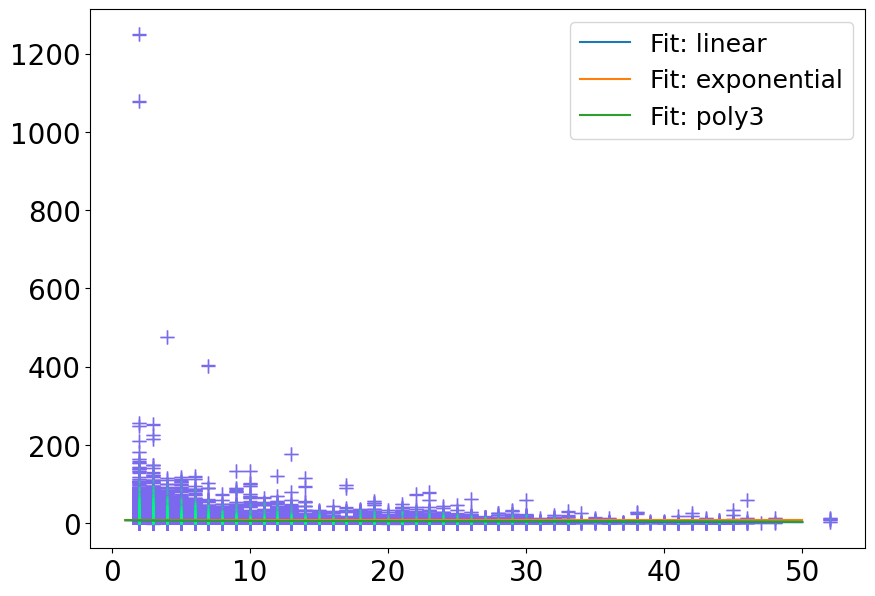

In [9]:
badbits = 2**23
suspectbits = 2**16

#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['NVISITS'] >= 1) & (~np.isnan(star['NVISITS'])) & (~np.isnan(star['VSCATTER'])) & (star['VSCATTER'] > 1)

cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, star['NVISITS'][cut1], star['VSCATTER'][cut1], 0, \
                         star['VERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

expA, expB, expC, expD  = mcFit4(exponential, star['NVISITS'][cut1], star['VSCATTER'][cut1], 0, \
                         star['VERR'][cut1],p0=[150,-0.1,0,0])
print(f'EXPONENTIAL: {expA:.3f}, {expB:.3f}, {expC:.3f}, {expD:.3f}')

poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['NVISITS'][cut1], star['VSCATTER'][cut1], 0, \
                         star['VERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


# PLOT DATA AND ERROR BARS
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], xerr=0,
             yerr=(np.abs(star['VERR'][cut1])), ecolor='mediumslateblue',fmt='none', capsize=5, zorder=0)
ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='springgreen',alpha=0.1)


x_plot = np.linspace(1,50,70)


#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

#exponential fit
ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), label='Fit: exponential')

#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.024, 0.017
POLY2: 0.003, 0.027, 0.018
POLY3: 0.001, 0.005, 0.027, 0.017


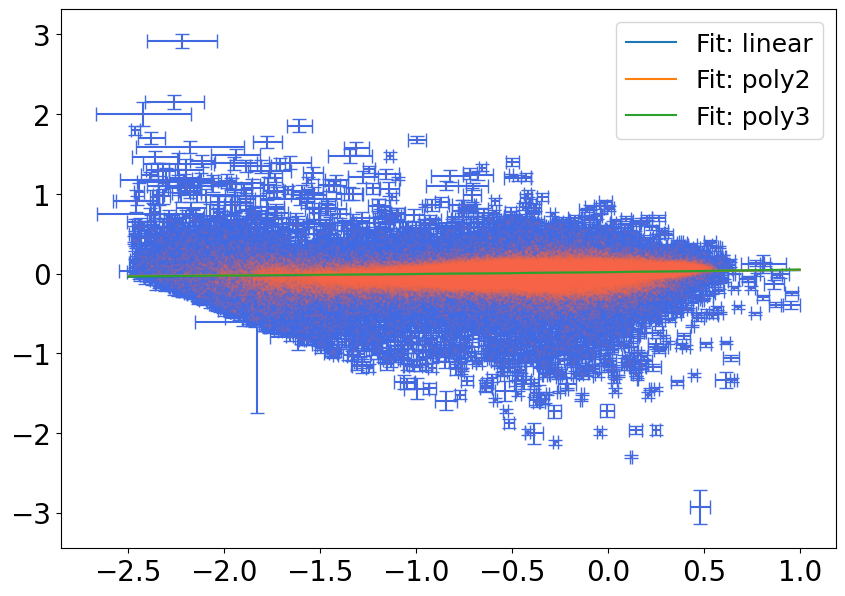

In [10]:
badbits = 2**23
suspectbits = 2**16

#Boolean Mask to remove bad data and other cuts
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (~np.isnan(star['Fe_H'])) & (~np.isnan(star['NI_FE'])) & (np.abs(star['Fe_H_ERR']) < 1.5)

cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['NI_FE_ERR'][cut1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

polyA, polyB, polyC  = mcFit3(poly2, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['NI_FE_ERR'][cut1],p0=[150,-0.1,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

poly3A, poly3B, poly3C, poly3D  = mcFit4(poly3, star['Fe_H'][cut1], star['NI_FE'][cut1], star['Fe_H_ERR'][cut1], \
                         star['NI_FE_ERR'][cut1],p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


# PLOT DATA AND ERROR BARS
ax1.errorbar((star['Fe_H'][cut1]),star['NI_FE'][cut1], xerr=(np.abs(star['Fe_H_ERR'][cut1])),
             yerr=(np.abs(star['NI_FE_ERR'][cut1])), ecolor='royalblue',fmt='none', capsize=5, zorder=0)
ax1.scatter(star['Fe_H'][cut1],star['NI_FE'][cut1],s=1,c='tomato',alpha=0.1)


x_plot = np.linspace(-2.5,1)


#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')

#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')

#poly3 fit
ax1.plot(x_plot,poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()